In [185]:
import pandas as pd
import plotly.express as px
from sqlalchemy import create_engine
import math
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier 
import matplotlib.pyplot as plt
from pypfopt import plotting 

In [186]:
# credentials to connect to db
uid = "user1116"
pwd = "password1116"
port = '3306'
hostname = "hult-mysql.cmsi20r5frst.us-west-1.rds.amazonaws.com"
database = "invest"

In [187]:
# verify that you have pymysql installed through pip
args = f"mysql+pymysql://{uid}:{pwd}@{hostname}:{port}/{database}"
engine = create_engine(args)

In [188]:
# get the accounts information for the client
# Inputs: first_name, last_name, email
# outputs of the query: all accounts
def get_client_data(client_id):
    get_client_acct_data = f'''SELECT client_id, hc.account_id, ad.acct_open_date, ticker, quantity, date
                            FROM account_dim AS ad
                                 INNER JOIN holdings_current hc on ad.account_id = hc.account_id
                            WHERE ad.client_id = {client_id}
                                  AND ad.acct_open_status = 1'''
    df = pd.read_sql_query(get_client_acct_data, engine)
    return df

In [189]:
# calculate the monthly returns
def calc_monthly_returns(p1,p0):
    mr = (p1/p0) - 1
    return mr 

# get the data for the tickers that belong to the account
def get_tickers_info_client(client_id):
    tickers_info = f'''SELECT pdn.ticker
                                 , security_name
                                 , major_asset_class
                                 , sec_type
                                 , date
                                 , value

                                FROM pricing_daily_new pdn
                                         INNER JOIN security_masterlist sm on pdn.ticker = sm.ticker
                                WHERE pdn.ticker in (SELECT ticker
                                                     FROM account_dim AS ad
                                                              INNER JOIN holdings_current hc on ad.account_id = hc.account_id
                                                     WHERE ad.client_id = {client_id}
                                                       AND ad.acct_open_status = 1)
                               AND pdn.date > '2019-01-02'
                               AND pdn.price_type = 'Adjusted'
                            ;'''
    df = pd.read_sql_query(tickers_info, engine)
    return df

# get the data for the tickers 
def get_tickers_info_all_market():
    tickers_info = f'''SELECT pdn.ticker
                                 , security_name
                                 , major_asset_class
                                 , sec_type
                                 , date
                                 , value

                                FROM pricing_daily_new pdn
                                         INNER JOIN security_masterlist sm on pdn.ticker = sm.ticker
                                WHERE pdn.ticker in (SELECT ticker
                                                     FROM account_dim AS ad
                                                              INNER JOIN holdings_current hc on ad.account_id = hc.account_id)
                                AND pdn.date > '2019-01-02'
                                AND pdn.price_type = 'Adjusted'
                            ;'''
    df = pd.read_sql_query(tickers_info, engine)
    return df

In [190]:
#calculate returns and covariance matrix
def returns_covariance(all_market_tickets,tickers_df):    
    new_asset_values = []
    # {'alternatives':{{'ticker1':weight1}, }, ...}
    asset_classes = ['alternatives','equity','fixed_income']
    yearly_returns = []
    for asset in asset_classes:
        asset_data = tickers_df[tickers_df.asset_class_grouped == asset]
        
        if asset_data.shape[0] == 0:
            asset_data = all_market_tickets[all_market_tickets.asset_class_grouped == asset]  
            
        asset_values = asset_data.groupby('date').mean().reset_index()
        
        # calculate the returns
        min_date = asset_values.date.min()
        max_date = asset_values.date.max()
        p0 = asset_values[asset_values.date == min_date].value
        p1 = asset_values[asset_values.date == max_date].value
        assert len(p0) == 1
        assert len(p1) == 1

        returns = calc_monthly_returns(p1.values[0],p0.values[0])
        if not np.isnan(returns):
            yearly_returns.append(returns)
        else:
            yearly_returns.append(0)

        new_asset_values.append(asset_values.value.values)

    #calculate the covariance matrix
    covariance_matrix = np.cov(new_asset_values)    

    
    return yearly_returns, covariance_matrix 

In [191]:
client_id = 724
tickers_info_all_market = get_tickers_info_all_market()
tickers_info_client = get_tickers_info_client(client_id)
client_data = get_client_data(client_id)

# grouping
asset_classes_grouped = {'commodities':'alternatives',
                 'equty':'equity',
                 'fixed income':'fixed_income',
                 'fixed income corporate':'fixed_income'}

# group major assets classes into 3
tickers_info_all_market['asset_class_grouped'] = tickers_info_all_market.major_asset_class
for key,value in asset_classes_grouped.items():
    tickers_info_all_market.loc[tickers_info_all_market.asset_class_grouped == key,'asset_class_grouped'] = value
    
# group major assets classes into 3
tickers_info_client['asset_class_grouped'] = tickers_info_client.major_asset_class
for key,value in asset_classes_grouped.items():
    tickers_info_client.loc[tickers_info_client.asset_class_grouped == key,'asset_class_grouped'] = value

In [192]:
yearly_returns, covariance_matrix = returns_covariance(tickers_info_all_market,tickers_info_client)

## Efficient frontier!

In [215]:
ef = EfficientFrontier(yearly_returns, covariance_matrix)

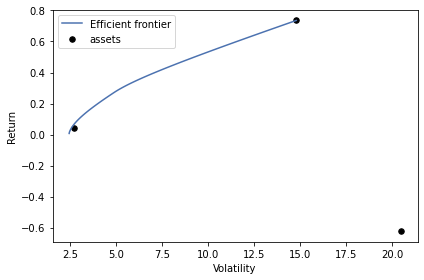

In [216]:
# plotting results
risk_range = np.linspace(0.10, 0.40, 100)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax)
plt.savefig('effi_front.png')

## Optimal weights

Historic risk for growth portfolios = 13.5%

In [230]:
# the order of the weights 'alternatives','equity','fixed_income'
ef2 = EfficientFrontier(yearly_returns, covariance_matrix)
optimal_weights = ef2.efficient_risk(10)

In [231]:
labeled_optimal_weights = {'fixed_income':optimal_weights[0],'equity':optimal_weights[1],'alternatives':optimal_weights[2]}

## Current weights

In [232]:
assets_classes = tickers_info_all_market[['asset_class_grouped','ticker']].drop_duplicates() 
portfolio_weights = pd.DataFrame({'asset':[],'current_quantity':[]})

for asset_class in assets_classes.asset_class_grouped.unique():
    tickers_filtered = assets_classes[assets_classes.asset_class_grouped == asset_class].ticker.values  
    
    # calculate the quantity for each asset class
    quantity = client_data.loc[client_data.ticker.isin(tickers_filtered)].quantity.sum()
    portfolio_weights_temp = pd.DataFrame({'asset':[asset_class],'current_quantity':[quantity]})
    portfolio_weights = pd.concat([portfolio_weights,portfolio_weights_temp])

In [233]:
portfolio_weights

,asset,current_quantity
0,alternatives,20937.0
0,equity,9853.0
0,fixed_income,7522.0


## Recommendation 

In [234]:
portfolio_weights['weight'] = portfolio_weights['current_quantity']/portfolio_weights['current_quantity'].sum()*100
portfolio_weights['optimal_weight'] = (portfolio_weights.asset.apply(lambda x: labeled_optimal_weights[x]))*100

In [235]:
portfolio_weights['difference'] = (portfolio_weights['optimal_weight'] - portfolio_weights['weight'])
portfolio_weights

,asset,current_quantity,weight,optimal_weight,difference
0,alternatives,20937.0,54.648674,4.239145e-07,-54.648674
0,equity,9853.0,25.717791,8.510015e+01,59.382358
0,fixed_income,7522.0,19.633535,1.489985e+01,-4.733685


In [236]:
portfolio_weights.style.format({'optimal_weight':'{:.4f}','weight':'{:.4f}','difference':'{:.4f}'})

,asset,current_quantity,weight,optimal_weight,difference
0,alternatives,20937.000000,54.6487,0.0000,-54.6487
0,equity,9853.000000,25.7178,85.1001,59.3824
0,fixed_income,7522.000000,19.6335,14.8999,-4.7337


In [237]:
tickers_info_all_market.head()

,ticker,security_name,major_asset_class,sec_type,date,value,asset_class_grouped
0,BCI,abrdn Bloomberg All Commodity Strategy K-1 Fre...,commodities,etf,2022-09-09,27.420000,alternatives
1,BCI,abrdn Bloomberg All Commodity Strategy K-1 Fre...,commodities,etf,2022-09-08,26.879999,alternatives
2,BCI,abrdn Bloomberg All Commodity Strategy K-1 Fre...,commodities,etf,2022-09-07,26.780001,alternatives
3,BCI,abrdn Bloomberg All Commodity Strategy K-1 Fre...,commodities,etf,2022-09-06,27.110001,alternatives
4,BCI,abrdn Bloomberg All Commodity Strategy K-1 Fre...,commodities,etf,2022-09-02,27.629999,alternatives


In [239]:
desired_tickers = ['TIP',
'ECL',
'CNC',
'SPG',
'CHD',
'GLTR']
final_df = tickers_info_all_market.loc[tickers_info_all_market.ticker == desired_tickers[0],['date']]
for dticker in desired_tickers:
    final_df[dticker] = tickers_info_all_market.loc[tickers_info_all_market.ticker == dticker,['value']].values
    print(final_df)
    # final_df[dticker] = not_final_df.values
final_df.head()

              date         TIP
353949  2022-09-09  111.099998
353950  2022-09-08  111.050003
353951  2022-09-07  111.669998
353952  2022-09-06  111.209999
353953  2022-09-02  112.279999
...            ...         ...
354873  2019-01-09   96.656929
354874  2019-01-08   96.542953
354875  2019-01-07   96.464035
354876  2019-01-04   96.525436
354877  2019-01-03   96.727097

[929 rows x 2 columns]
              date         TIP         ECL
353949  2022-09-09  111.099998  172.639999
353950  2022-09-08  111.050003  170.919998
353951  2022-09-07  111.669998  170.919998
353952  2022-09-06  111.209999  163.029999
353953  2022-09-02  112.279999  161.639999
...            ...         ...         ...
354873  2019-01-09   96.656929  143.632431
354874  2019-01-08   96.542953  143.806244
354875  2019-01-07   96.464035  142.077377
354876  2019-01-04   96.525436  141.662048
354877  2019-01-03   96.727097  136.707199

[929 rows x 3 columns]
              date         TIP         ECL        CNC
353949  20

,date,TIP,ECL,CNC,SPG,CHD,GLTR
353949,2022-09-09,111.099998,172.639999,91.989998,103.769997,81.559998,82.639999
353950,2022-09-08,111.050003,170.919998,91.260002,102.540001,80.839996,81.879997
353951,2022-09-07,111.669998,170.919998,89.330002,101.709999,81.540001,81.580002
353952,2022-09-06,111.209999,163.029999,88.330002,99.330940,80.230003,80.110001
353953,2022-09-02,112.279999,161.639999,90.050003,98.829559,84.180000,80.610001


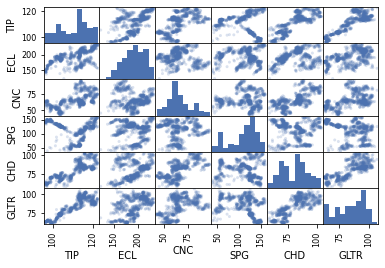

In [240]:
pd.plotting.scatter_matrix(final_df, alpha=0.2)
plt.savefig('correlation.png')